# Baseline Code
*Last updated: 22 March 2019 by Miroslav Gasparek*

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Original code is based on the EE3 - 25 Deep Learning Coursework assignment. The amendments to the code are done by the Miroslav Gasparek.

## Safety Check

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 12.9 GB  | Proc size: 142.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Data download and preparation

In [3]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

fatal: destination path 'keras_triplet_descriptor' already exists and is not an empty directory.


In [4]:
# Change directory to keras triplet desriptor
%cd /content/keras_triplet_descriptor    


/content/keras_triplet_descriptor


In [5]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


--2019-03-22 21:33:25--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 21:33:26--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 21:33:26--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

In [6]:
# Unzip and extract the data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

replace hpatches/v_man/e3.anisjitter? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Importing of the necessary modules

In [7]:
# Import appropriate Python modules and TensorFlow for the backend
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

# Import plotting module
import matplotlib.pyplot as plt

# Import Keras and associated modules
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

# Import the appropriate callbacks
from keras.callbacks import Callback


# Import the custom functions needed for the HPatches data manipulation
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


In [0]:
# Fix the random numbers generator to obtain the reproducible results
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

## Load the data
We use the split `a` as specified.

In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


## Models and loss

Here we define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net



def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Generation of training and validation data for the denoising network
We take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data).


In [11]:
# Generate the samples for the denoising training and validation
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
# denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
# denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


In [12]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# Get the number of training and testing samples 
# for the denoising network
ind_train = 0
ind_val = 0

while True:
    try:
      arr = np.shape(denoise_generator.get_images(ind_train))
      ind_train = ind_train+1
    except IndexError:
        break
        
while True:
    try:
      arr = np.shape(denoise_generator_val.get_images(ind_val))
      ind_val = ind_val+1
    except IndexError:
        break
        
print('Number of training samples: ', ind_train)
print('Number of validation samples: ', ind_val)


Number of training samples:  45952
Number of validation samples:  13648


In [14]:
denoise_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
up_samplin

In [15]:
descriptor_model = get_descriptor_model(shape)
descriptor_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
___________________________

## Define histories callback

We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model. Also, define the class that enables us to plot the learning rate within a single epoch.

In [0]:
from keras.callbacks import Callback

class Histories(Callback):

    def on_train_begin(self,logs={}):
        self.losses = []
        self.mean_absolute_errors = []
        self.accuracies = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.mean_absolute_errors.append(logs.get('mae'))
        self.accuracies.append(logs.get('acc'))

## Default denoising neural network

In [17]:
# Make the callback
histories_denoise = Histories()

# Make the model
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
for e in range(epochs):
  denoise_history = denoise_model.fit_generator(generator=denoise_generator, 
                                                epochs=1, verbose=1, 
                                                validation_data=denoise_generator_val,
                                                callbacks=[histories_denoise])
  ### Saves optimizer and weights with the corresponding epoch number
#   save_string="denoise_e"+str(e+1)+".h5"
  denoise_model.save("denoise.h5") 
  ### Uploads files to external hosting
#   server_string = "file=@"+save_string
  !curl -F "file=@denoise.h5" https://file.io
    

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
919/919 [==============================] - 28s 30ms/step - loss: 9.4756 - mean_absolute_error: 9.4756 - val_loss: 5.9690 - val_mean_absolute_error: 5.9690
{"success":true,"key":"wxvMvv","link":"https://file.io/wxvMvv","expiry":"14 days"}

##  Plotting the learning curves for the baseline approach
Below, we plot the learning curve for the basline approach. We use the callback defined above to access the loss vs. number of iterations.

In [0]:
def plot_lc(*histories, titlestring='Training Loss', legstr=['Baseline'],
            loss_form='',
            parameters='',
            ylimit=[0,200]):
  """Function plots the learning curve as a function of no. of iterations."""
  
  fig = plt.figure()
  fig.set_size_inches(6, 6)
  axes = plt.axes()
  
  for ind in range(len(histories)):
    axes.plot(histories[ind].losses)
    
  axes.legend(legstr,fontsize=15)
  axes.set_title(titlestring +
                 '\n' + parameters,
                 fontsize=20)
  axes.set_ylabel(loss_form + ' Loss',fontsize=15)
  axes.set_xlabel('Iterations',fontsize=15)
  axes.set_ylim(ylimit)

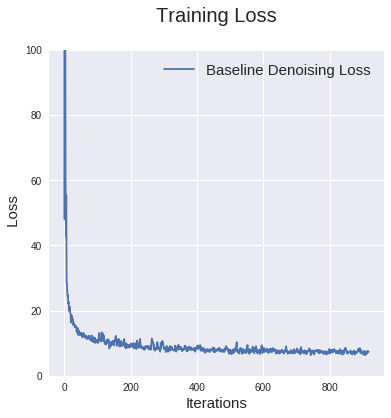

In [34]:
plot_lc(histories_denoise, 
        legstr=['Baseline Denoising Loss'],
        ylimit=[0,100])

## Different loss functions and different learning rates
Here we try to compare default net with different learning rates for the SGD (original LR vs. 10x original LR) and different loss functions (mean absolute errors vs. mean squared logarithmic error)

In [0]:
from google.colab import files
files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


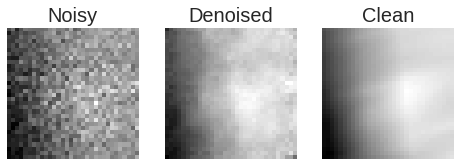

In [22]:
plot_denoise(denoise_model)

## Training a Descriptor Network

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [0]:
# Make the callback to history
histories_descriptor = Histories()

shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

## Creating the training and validation files for the descriptor

In [25]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model, use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), 
                                       num_triplets=100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), 
                                  num_triplets=10000)


Using denoised patches
100%|██████████| 116/116 [00:35<00:00,  2.22it/s]
Denoising patches...
100%|██████████| 15589/15589 [05:06<00:00, 50.84it/s]


100%|██████████| 100000/100000 [00:01<00:00, 60611.94it/s]


Using denoised patches
100%|██████████| 116/116 [00:21<00:00,  5.41it/s]
Denoising patches...
100%|██████████| 9525/9525 [03:24<00:00, 46.67it/s]


100%|██████████| 10000/10000 [00:00<00:00, 75767.45it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

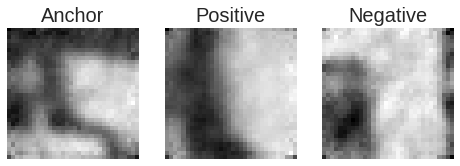

In [26]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [27]:
# Here we assume that the HPatches have been loaded

# Make the callback to history
histories_descriptor = Histories()

shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae','acc'])

epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

for e in range(epochs):
  
  descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, 
                                                           epochs=1, verbose=1, 
                                                           validation_data=val_generator,
                                                           callbacks=[histories_descriptor])
  
  ### Saves optimizer and weights
  descriptor_model_trip.save('descriptor.h5') 
  ### Uploads files to external hosting
  !curl -F "file=@descriptor.h5" https://file.io


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2171 - acc: 0.8675

100%|██████████| 100000/100000 [00:02<00:00, 36518.28it/s]


2000/2000 [==============================] - 172s 86ms/step - loss: 0.2171 - mean_absolute_error: 0.2171 - acc: 0.8675 - val_loss: 0.2162 - val_mean_absolute_error: 0.2162 - val_acc: 0.8662


100%|██████████| 10000/10000 [00:00<00:00, 65853.54it/s]


{"success":true,"key":"kwBrWY","link":"https://file.io/kwBrWY","expiry":"14 days"}

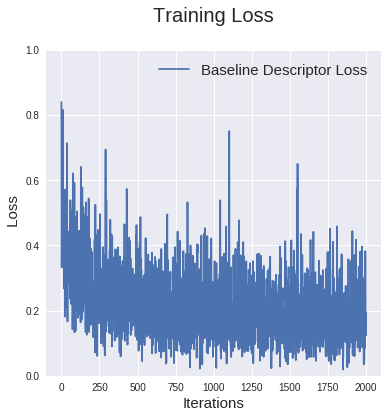

In [29]:
plot_lc(histories_descriptor, 
        legstr=['Baseline Descriptor Loss'],
        ylimit=[0,1])

## Generating descriptor files for evaluation

In [30]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████| 40/40 [07:39<00:00, 12.87s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [31]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification --more_info



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:48<00:00, 9253.80it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:46<00:00, 9393.40it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:44<00:00, 9593.40it/s]
>> Verification task finished in 329 secs  
Verification task results:
CUSTOM - Imbalanced variant (ap) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.837191  0.754878
Hard     0.774102  0.662508
Tough    0.689367  0.563424
Mean Average Precision is 0.713578


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [32]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching --more_info



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:08<00:00,  4.33s/it]
>> Matching task finished in 129 secs  
Matching task results:
CUSTOM - mAP 
    Easy       Hard      Tough      mean
--------  ---------  ---------  --------
0.230031  0.0852352  0.0298712  0.115046
Mean Average Precision is 0.115046




### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [33]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval --more_info


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x25b9a000 @  0x7fe1c1b581e7 0x7fe1b7403a41 0x7fe1b7466c13 0x7fe1b746899e 0x7fe1b7500748 0x5030d5 0x507641 0x504c28 0x502540 0x502f3d 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x506393 0x634d52 0x634e0a 0x6385c8 0x63915a 0x4a6f10 0x7fe1c1755b97 0x5afa0a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [04:10<00:00, 39.92it/s]
>> Retrieval task finished in 288 secs  
Retrieval task results:
CUSTOM - mAP 10K queries 
Noise         100       500      1000      5000     10000      15000      20000
-------  --------  --------  --------  --------  --------  ---------  ---------
Easy     0.759806  0.625655  0.571521  0.451521  0.403775  0.37812    0.361355
Hard     0.698152  0.512036  0.436021  0.281933  0

## Compressing and saving the CSV files 

This will be done for the Competition submission next week.